In [1]:
%matplotlib inline

import numpy as np
import cv2
import copy
import math as mt
from scipy.signal import find_peaks
from sympy import Point, Line, Symbol, pi
from skimage import draw
import matplotlib.pyplot as plt
import time
import math
from statistics import mode

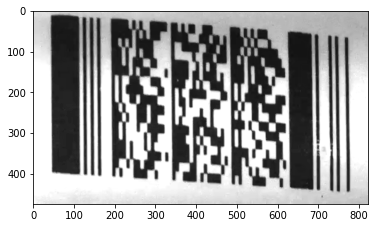

In [2]:
INPUT_IMAGE_PATH = '/media/Work/Codes/Private/pdf417-decoder/output/images/'\
                   'Crop/15-02-2021/17:00:00/15-02-2021_17:42:57:272_009/00031_1.jpg'

input_image = cv2.imread(INPUT_IMAGE_PATH, 0)
plt.imshow(input_image, cmap='gray')

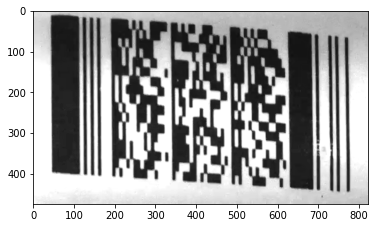

In [3]:
def convert_image(var_image):
    d = np.ndim(var_image)
    
    if d == 3:
        var_gray_img = cv2.cvtColor(var_image, cv2.COLOR_BGR2GRAY)
    else:
        var_gray_img = var_image
    
    return var_gray_img

converted_image = convert_image(input_image)
plt.imshow(converted_image, cmap='gray')

In [4]:
def all_corners(var_gray_img, threshold=0.3):

    corners = cv2.goodFeaturesToTrack(var_gray_img, 1000, threshold, 10)
    var_all_corners = np.array(tuple(map(np.ravel, corners)), dtype=np.int0)
    
    return var_all_corners

var_all_corners = all_corners(converted_image)
var_all_corners.shape

(230, 2)

In [5]:
def image_corners(var_gray_img):
    '''Find corner indices of the Image'''

    row, col = var_gray_img.shape
    img_area = row * col
    var_image_corners = [[0, 0],
                          [col - 1, 0],
                          [col - 1, row - 1],
                          [0, row - 1]]

    return var_image_corners

var_image_corners = image_corners(converted_image)
var_image_corners

[[0, 0], [821, 0], [821, 473], [0, 473]]

In [6]:
def min_dist(point, points_array):
    '''Find the min distance between reference points with the points'''
    
    x1, y1 = point
    dist_arr = []
    for i in range(len(points_array)):
        x2, y2 = points_array[i]
        d = mt.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        dist_arr.append(d)

    return min(dist_arr), np.argmin(dist_arr)


def distances(var_all_corners, var_image_corners):
    '''Find the distances of corners of the Barcode'''
    
    var_distances = [min_dist(point, var_all_corners) for point in var_image_corners]
    
    return var_distances


var_distances = distances(var_all_corners, var_image_corners)
var_distances

[(125.29964086141668, 225),
 (201.64572894063488, 173),
 (59.682493245507096, 209),
 (92.9623579735368, 127)]

In [7]:
def order_points(points):
    rect = np.zeros((4, 2), dtype="float32")

    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]

    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]

    return rect

In [8]:
def barcode_corners(var_all_corners, var_distances):
    '''Get Barcode corner co-ordinates'''

    var_barcode_corners = order_points(np.array([var_all_corners[
                                                               var_distances[i][1]]
                                                           for i in range(4)]))
    return var_barcode_corners

var_barcode_corners = barcode_corners(var_all_corners, var_distances)
var_barcode_corners

array([[124.,  18.],
       [627.,  55.],
       [770., 442.],
       [ 49., 394.]], dtype=float32)

In [9]:
def find_top_border_angle(var_barcode_corners):
    '''Find Angle of Top border'''
    
    P1 = var_barcode_corners[0][:]
    P2 = var_barcode_corners[1][:]

    top_line_angle = 90 - round(math.degrees(math.atan2((round(P1[0], 2) - 
                                                         round(P2[0], 2)), 
                                                        (round(P1[1], 2) - 
                                                         round(P2[1], 2)))), 0)

    return top_line_angle

top_line_angle = find_top_border_angle(var_barcode_corners)
top_line_angle

184.0

In [10]:
def point_angles(var_barcode_corners):
    '''Get Barcode corner co-ordinates'''
    
    points = list(map(Point, var_barcode_corners))

    var_angle_arr = []
    for i in range(len(points)):
        l1 = Line(points[i], points[i - 1])
        try:
            l2 = Line(points[i], points[i + 1])
        except:
            l2 = Line(points[i], points[-len(points)])

        angle = l1.angle_between(l2)
        var_angle_arr.append(float(angle * (180 / pi)))
    
    return var_angle_arr

var_angle_arr = point_angles(var_barcode_corners)
var_angle_arr

[97.07360206301648, 114.48675039985703, 65.91147227274996, 82.52817526437654]

In [11]:
def associated_pts(var_angle_arr):

    var_associat_pts = []
    angle_variance = []
    angle_diff = []
    for i in range(len(var_angle_arr)):
        if i:
            angles = [var_angle_arr[i], var_angle_arr[i - 1]]
            var_associat_pts.append([i, angles])
        else:
            angles = [var_angle_arr[i], var_angle_arr[-1]]
            var_associat_pts.append([i, angles])
        angle_variance.append([i, np.var(angles)])
        angle_diff.append
        
    return var_associat_pts, angle_variance

var_associat_pts, angle_variance = associated_pts(var_angle_arr)
print(f'var_associat_pts: {var_associat_pts}')
print(f'angle_variance: {angle_variance}')

var_associat_pts: [[0, [97.07360206301648, 82.52817526437654]], [1, [114.48675039985703, 97.07360206301648]], [2, [65.91147227274996, 114.48675039985703]], [3, [82.52817526437654, 65.91147227274996]]]
angle_variance: [[0, 52.89236018864821], [1, 75.8044337502032], [2, 589.8894112814517], [3, 69.02870457798295]]


In [12]:
def vert_dist(var_barcode_corners, var_all_corners):

    p1, p2 = var_barcode_corners[:2]
    ppcular_dist = []
    for i in range(len(var_all_corners)):
        p3 = var_all_corners[i]
        d = abs(np.cross(p2 - p1, p3 - p1) / np.linalg.norm(p2 - p1))
        ppcular_dist.append(d)
    var_vert_dist = np.array(ppcular_dist)
    
    return var_vert_dist

var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)
var_vert_dist.shape

(230,)

In [13]:
def sorted_distances(var_vert_dist):
    var_sorted_dist = np.sort(var_vert_dist)
    
    return var_sorted_dist

def distance_gradients(var_sorted_dist):
    var_dist_grad = np.gradient(var_sorted_dist)
    
    return var_dist_grad

def highest_peak(distance_gradients):
    var_highest_peak = np.max(distance_gradients)
    
    return var_highest_peak

def get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.7):

    peak_indices, peaks = find_peaks(var_dist_grad, height=height * var_highest_peak)
    peak_indices = np.append(peak_indices, len(var_sorted_dist))

    var_peak_indices, var_peaks = peak_indices, peaks['peak_heights']
    
    return var_peak_indices, var_peaks

var_sorted_dist = sorted_distances(var_vert_dist)
var_dist_grad = distance_gradients(var_sorted_dist)
var_highest_peak = highest_peak(var_dist_grad)

var_peak_indices, var_peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.7)
var_peak_indices

array([  5,  10,  14,  23,  31,  38,  55,  71,  85,  98, 112, 130, 161,
       174, 190, 230])

In [14]:
def search_threshold(converted_image, in_threshold_arr=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]):

    variance_data_arr = []
    peaks_data_arr = []
    out_threshold_arr = []
    
    present_flag = False

    for threshold in in_threshold_arr:

        try:
            # print(threshold_arr)
            print(threshold)
            var_all_corners = all_corners(converted_image, threshold=threshold)
            var_image_corners = image_corners(converted_image)
            var_distances = distances(var_all_corners, var_image_corners)
            var_barcode_corners = barcode_corners(var_all_corners, var_distances)
            top_line_angle = find_top_border_angle(var_barcode_corners)
            var_angle_arr = point_angles(var_barcode_corners)
            var_associat_pts, angle_variance = associated_pts(var_angle_arr)
            var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)
            print(1)
            
            
            var_sorted_dist = sorted_distances(var_vert_dist)
            var_dist_grad = distance_gradients(var_sorted_dist)
            var_highest_peak = highest_peak(var_dist_grad)
            
            peak_indices, peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.7)
            print(2)
            variance_data = [np.var(peaks), np.var(np.gradient(peak_indices[:-1]))]
            print(f'peaks: {peak_indices}')
            print(f'len(peaks): {len(peaks)}')
            print(f'peaks_diff: {np.diff(np.array(peak_indices))}')
            peaks_data_arr.append(peaks)
            variance_data_arr.append(variance_data)
            out_threshold_arr.append(threshold)
            present_flag = True
            
        except:
            pass

    if present_flag:
        variance_data_arr = np.transpose(variance_data_arr)
        peaks_data_arr = peaks_data_arr

    else:
        variance_data_arr = np.array([])
        peaks_data_arr = np.array([])
    
    return out_threshold_arr, peaks_data_arr, variance_data_arr

threshold_arr, peaks_data_arr, variance_data_arr = search_threshold(converted_image)

print(f'threshold_arr: {threshold_arr}')
print(f'peaks_data_arr: {peaks_data_arr}')
print(f'variance_data_arr: {variance_data_arr}')

0.1
1
2
peaks: [ 48  69  84 103 115 136 177 196 214 236 272 288 307 326 357]
len(peaks): 14
peaks_diff: [21 15 19 12 21 41 19 18 22 36 16 19 19 31]
0.15
1
2
peaks: [ 38  53  67  84  95 113 133 152 171 188 210 245 261 281 298 328]
len(peaks): 15
peaks_diff: [15 14 17 11 18 20 19 19 17 22 35 16 20 17 30]
0.2
1
2
peaks: [ 31  40  54  67  78  96 115 133 153 169 191 223 240 259 276 305]
len(peaks): 15
peaks_diff: [ 9 14 13 11 18 19 18 20 16 22 32 17 19 17 29]
0.25
1
2
peaks: [ 20  26  37  47  57  74  91 105 120 135 157 188 203 220 237 265]
len(peaks): 15
peaks_diff: [ 6 11 10 10 17 17 14 15 15 22 31 15 17 17 28]
0.3
1
2
peaks: [  5  10  14  23  31  38  55  71  85  98 112 130 161 174 190 230]
len(peaks): 15
peaks_diff: [ 5  4  9  8  7 17 16 14 13 14 18 31 13 16 40]
0.35
1
2
peaks: [  6  13  18  21  58  68 182]
len(peaks): 6
peaks_diff: [  7   5   3  37  10 114]
0.4
1
2
0.45
1
2
threshold_arr: [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
peaks_data_arr: [array([7.03025518, 8.22689436, 8.0149895 , 8.8127

In [15]:
def optim_threshold(threshold_arr, peaks_data, variance_data):

    save_var = {'variance': variance_data, 'peaks': peaks_data}

    if len(peaks_data):
        print(f'[max(peak) for peak in peaks_data]: {[max(peak) for peak in peaks_data]}')
        maximum = mode([round(max(peak)) for peak in peaks_data])
#         maximum = max([max(peak) for peak in peaks_data])
        cap = 0.7 * maximum

        masks = [peak >= cap for peak in peaks_data]
        sizes = [np.size(peak, axis=0) for peak in peaks_data]
        
        print(f'masks: {masks}')
        print(f'sizes: {sizes}')
        print(f'mode(sizes): {mode(sizes)}')

        good_heights = [np.count_nonzero(mask) == size == mode(sizes) for mask, size in zip(masks, sizes)]
        order = variance_data.argsort()
        ranks = order.argsort()
        total_variance = np.var(ranks, axis=0)
        weighted_ranks = np.sum(ranks, axis=0)
        cum_ranks = np.sum([total_variance, weighted_ranks], axis=0)
        print(f'variance_data: {variance_data}')
        print(f'total_variance: {total_variance}')
        print(f'cum_ranks: {cum_ranks}')
        
        index = np.argmin(cum_ranks)
        
        print(f'good_heights: {good_heights}')
        print(f'index: {index}')

        if good_heights[index]:
            var_optim_threshold = threshold_arr[index]
            return var_optim_threshold
        else:
            return None
    
    return None

start = time.time()
var_optim_threshold = optim_threshold(threshold_arr, peaks_data_arr, variance_data_arr)
print(f'Time taken: {time.time() - start}')
print(f'var_optim_threshold: {var_optim_threshold}')

[max(peak) for peak in peaks_data]: [9.037118802976707, 9.037118802976707, 9.025628271209186, 9.05668686815072, 10.427096390379864, 12.733248817543554]
masks: [array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True]), array([ True,  True,  True,  True,  True,  True])]
sizes: [14, 15, 15, 15, 15, 6]
mode(sizes): 15
variance_data: [[ 0.41998532  0.27534425  0.43651821  0.47860291  0.59683852  1.52798231]
 [26.56122449 15.17333333 20.59333333 26.12888889 32.0

In [28]:
def class_centers(var_peak_indices):
    '''To calculate centroids by averaging distance measures between peaks'''

    centroids = []
    for i in range(len(var_peak_indices)):
        if i == 0:
            min_idx = 0
            max_idx = var_peak_indices[i]
        elif i == len(var_peak_indices) - 1:
            min_idx = var_peak_indices[i - 1]
            max_idx = len(var_sorted_dist)
        else:
            min_idx = var_peak_indices[i - 1]
            max_idx = var_peak_indices[i]

        centroids.append(np.mean(var_sorted_dist[min_idx: max_idx]))

    return centroids


var_all_corners = all_corners(converted_image, threshold=0.3)
var_image_corners = image_corners(converted_image)
var_distances = distances(var_all_corners, var_image_corners)
var_barcode_corners = barcode_corners(var_all_corners, var_distances)
top_line_angle = find_top_border_angle(var_barcode_corners)
var_angle_arr = point_angles(var_barcode_corners)
var_associat_pts, angle_variance = associated_pts(var_angle_arr)
var_vert_dist = vert_dist(var_barcode_corners, var_all_corners)

var_sorted_dist = sorted_distances(var_vert_dist)
var_dist_grad = distance_gradients(var_sorted_dist)
var_highest_peak = highest_peak(var_dist_grad)

peak_indices, peaks = get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.7)
centroids = class_centers(var_peak_indices)
diff = np.diff(np.array(centroids)).tolist()
sorted(diff)

[16.51125459222806,
 19.074607238796336,
 21.622115662635736,
 22.067366312583985,
 22.289473627898417,
 22.477919456004045,
 22.63105917119111,
 22.826116896273334,
 23.05474459509705,
 23.375051058814847,
 25.179842798975216,
 25.793520523562748,
 32.75732785002688,
 33.07887338350463,
 37.581265863593046]

In [29]:
def labels(var_vert_dist, var_sorted_dist, var_peak_indices):
    '''To get the labels of the co-ordinates with centroids as reference'''

    labels = copy.deepcopy(var_vert_dist)
    for i in range(len(var_peak_indices)):
        if i == 0:
            min_idx = 0
            max_idx = var_peak_indices[i]
        elif i == len(var_peak_indices) - 1:
            min_idx = var_peak_indices[i - 1]
            max_idx = len(var_sorted_dist) - 1
        else:
            min_idx = var_peak_indices[i - 1]
            max_idx = var_peak_indices[i]

        if i != len(var_peak_indices) - 1:
            labels[np.where((var_vert_dist < var_sorted_dist[max_idx]) &
                            (var_vert_dist >= var_sorted_dist[min_idx]))] = i
        else:
            labels[np.where((var_vert_dist <= var_sorted_dist[max_idx]) &
                            (var_vert_dist >= var_sorted_dist[min_idx]))] = i

    var_labels = labels.astype(int)
    
    return var_labels

var_labels = labels(var_vert_dist, var_sorted_dist, var_peak_indices)
var_labels

array([10, 11,  9, 12, 11, 15, 12, 12, 12, 15, 12,  3,  8, 12, 10,  9,  6,
       10, 13,  9, 12, 14, 12,  8, 11,  8, 10,  9, 11, 15, 12, 13, 10, 11,
        6, 14,  6,  5, 12, 12, 15, 13, 15,  8, 12, 12,  9, 10,  9, 11, 11,
       14, 15,  9, 13, 15, 15, 15, 14, 12, 15, 11,  7, 14,  6, 12,  3, 10,
       14,  9, 13,  6,  8,  7, 13,  7, 10,  7, 12, 15, 15,  4, 15, 10, 12,
        7, 15, 14, 13,  5, 15,  9,  7, 12,  0, 10, 14, 12,  8, 15, 14,  4,
       11, 13,  6, 12,  7, 13, 13,  9, 12,  3, 15,  7, 15,  8, 15, 13, 14,
        6, 15, 14,  5, 12, 12,  4,  4, 15,  6,  8, 11,  6, 12, 12,  3, 15,
       15, 10, 14,  1, 15,  7, 11, 14, 15,  8, 12, 15, 10, 12, 11, 12,  6,
       14,  6,  3, 15, 15,  8, 12,  2, 11, 15, 15, 10,  8, 14,  2,  7, 13,
        6,  8,  0,  0,  1,  3,  7,  1, 14,  5,  7,  9, 15, 15, 15, 12,  6,
        6,  5, 13,  6, 11, 11,  7,  4, 11, 15, 15,  0,  3, 10, 11,  5,  7,
        4, 15,  2,  6,  7, 15,  3,  8,  1,  9, 11, 15,  5,  9, 15,  4,  8,
        6,  7, 15,  3,  0

In [30]:
def center_coordinates(var_labels):
    '''Find the centroid of the coordinates'''

    var_center_coord = []
    concur_feat_sep = []
    coords = var_all_corners
    
    for i in range(len(np.unique(var_labels))):
        selected_bin = coords[np.where(var_labels == i)]
        centroid = np.mean(selected_bin, axis=0)
        var_center_coord.append(centroid)
        concur_feat_sep.append(centroid.astype('int'))
    
    return var_center_coord, concur_feat_sep


var_center_coord, concur_feat_sep = center_coordinates(var_labels)

print(f'\nvar_center_coord: {var_center_coord}\n')
print(f'\nconcur_feat_sep: {concur_feat_sep}\n')


var_center_coord: [array([371.2,  35.4]), array([380.4,  54.2]), array([416.75,  76.  ]), array([442.77777778, 103.77777778]), array([452.625, 129.75 ]), array([411.57142857, 148.85714286]), array([383.        , 169.29411765]), array([432.625, 194.625]), array([424.42857143, 216.71428571]), array([387.84615385, 237.46153846]), array([439.21428571, 264.35714286]), array([470.38888889, 289.        ]), array([474.67741935, 322.16129032]), array([463.92307692, 354.53846154]), array([403.75, 373.  ]), array([413.5, 411.4])]


concur_feat_sep: [array([371,  35]), array([380,  54]), array([416,  76]), array([442, 103]), array([452, 129]), array([411, 148]), array([383, 169]), array([432, 194]), array([424, 216]), array([387, 237]), array([439, 264]), array([470, 289]), array([474, 322]), array([463, 354]), array([403, 373]), array([413, 411])]



In [31]:
def round(self, data):
    return np.round(data, 3)


def concurrent_feature_sep(var_barcode_corners):

    (p1, p2) = var_barcode_corners[:2]
    top_border = Line(Point(p1), Point(p2))
    mid_point = Point(p1).midpoint(Point(p2))
    ppcular_line = top_border.perpendicular_line(mid_point)

    var_concur_feat_sep = []
    for centroid in var_center_coord:
        parallel_line = top_border.parallel_line(centroid)
        feature_sep = ppcular_line.intersection(parallel_line)
        var_concur_feat_sep.append(feature_sep[0])
    
    return var_concur_feat_sep

var_concur_feat_sep = concurrent_feature_sep(var_barcode_corners)
var_concur_feat_sep

[Point2D(238833811/635945, 22716286/635945),
 Point2D(237990581/635945, 34179656/635945),
 Point2D(379361103/1017512, 74043795/1017512),
 Point2D(424615210000000001369/1144701000000000000, 112745580999999981389/1144701000000000000),
 Point2D(751112379/2035024, 251540103/2035024),
 Point2D(11684655249999999741/31797250000000000, 4630105000000003521/31797250000000000),
 Point2D(93057775176470584951/254378000000000000, 42743321411764750531/254378000000000000),
 Point2D(370617115/1017512, 192914767/1017512),
 Point2D(92231954142857136953/254378000000000000, 53970023571428651693/254378000000000000),
 Point2D(22948936423076925277/63594500000000000, 14975025153846123937/63594500000000000),
 Point2D(91365514571428569161/254378000000000000, 65748918285714316541/254378000000000000),
 Point2D(90949564388888889041/254378000000000000, 71403592388888886821/254378000000000000),
 Point2D(225845676532258049/635945000000000, 199284708629032469/635945000000000),
 Point2D(89720976384615376131/254378000000

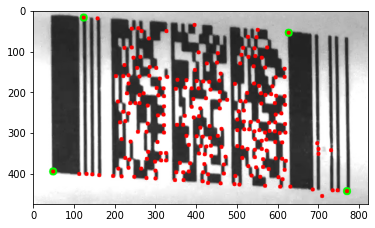

In [32]:
def overlay_corners(image, corners, radius, color, inplace=False):
    if not inplace:
        overlaid_image = copy.deepcopy(image)
    else:
        overlaid_image = image

    corners = tuple(map(tuple, corners))
    for corner in corners:
        cv2.circle(overlaid_image, corner, radius, color, -1)
    return overlaid_image


def overlay_lines(image, start, end, line_thickness, line_color, inplace=False):
    if not inplace:
        overlaid_image = copy.deepcopy(image)
    else:
        overlaid_image = image

    start, end = tuple(map(tuple, start)), tuple(map(tuple, end))
    for start_line, end_line in zip(start, end):
        cv2.line(overlaid_image, start_line, end_line, line_color, line_thickness)
    
    return overlaid_image


debug_image = cv2.merge((input_image, input_image, input_image))
debug_image = overlay_corners(debug_image, var_barcode_corners, 10, (0, 255, 0), inplace=True)
debug_image = overlay_corners(debug_image, var_all_corners, 5, (255, 0, 0), inplace=True)
plt.imshow(debug_image)

In [35]:
def line_count(var_concur_feat_sep, req_line_cnt):

    line_count = req_line_cnt
    (p1, p2) = var_concur_feat_sep[:2]
    (x, y), (s, t) = p1, p2
    d8 = max(abs(x - s), abs(y - t))
#     print(f'd8: {d8}')
    
    if line_count > (d8 / 2.2):
        line_count = int(d8 / 2.2)
    else:
        line_count += 1
        
#     print(f'line_count: {line_count}')
    var_norm_distance = 1 / line_count
    var_line_count = line_count - 1
    
    return var_line_count, var_norm_distance

var_line_count, var_norm_distance = line_count(var_concur_feat_sep, 3)

print(f'var_line_count: {var_line_count}')
print(f'var_norm_distance: {var_norm_distance}')

var_line_count: 3
var_norm_distance: 0.25


In [37]:
def line_prof(var_image_corners, var_center_coord, top_line_angle):
    line_prof_coor_arr = []
    y_borderpoints = var_image_corners[-1]
    x_borderpoints = var_image_corners[1]
    
    print(f'y_borderpoints: {y_borderpoints}')
    print(f'x_borderpoints: {x_borderpoints}')
    
    max_line_length = 20000
    
    x_angle = math.cos(top_line_angle * pi / 180.0)
    y_angle = math.sin(top_line_angle * pi / 180.0)

    print(f'x_angle: {x_angle}')
    print(f'y_angle: {y_angle}')
    
    for i in range(len(var_center_coord)):
        P1x, P1y = var_center_coord[i][0], var_center_coord[i][1]
        P1x = int(P1x)
        P1y = int(P1y)
        
        for j in range(max_line_length):
            P2x = int(round(P1x - j * x_angle, 0))
            P2y = int(round(P1y - j * y_angle, 0))
            
            if P2x in x_borderpoints or P2y in y_borderpoints:
                break

        for j in range(max_line_length):
            P3x = int(round(P1x + j * x_angle, 0))
            P3y = int(round(P1y + j * y_angle, 0))
            
            if P3x in x_borderpoints or P3y in y_borderpoints:
                break
                
            line_prof_coor_arr.append([(P3x, P3y), (P2x, P2y)])
    line_prof_coor_arr = np.asarray(line_prof_coor_arr)
    
    return line_prof_coor_arr

print(f'var_image_corners: {var_image_corners}')
line_prof_coor_arr = line_prof(var_image_corners, var_center_coord, top_line_angle)
line_prof_coor_arr

var_image_corners: [[0, 0], [821, 0], [821, 473], [0, 473]]
y_borderpoints: [0, 473]
x_borderpoints: [821, 0]
x_angle: 6.123233995736766e-17
y_angle: 1.0


array([], dtype=float64)

In [ ]:
def row_extraction(self, req_line_cnt=3):

    # start_t = time.time()
    Int_prof_points = []
    centroid = var_center_coord
    req_line_cnt = req_line_cnt / 2
    y_borderpoints = var_image_corners[-1]
    x_borderpoints = var_image_corners[1]
    max_line_length = 20000
    x_angle = math.cos(top_line_angle * pi / 180.0)
    y_angle = math.sin(top_line_angle * pi / 180.0)
    int_prof = []
    dup_check = []

    for i in range(len(centroid) - 1):

        start = int(round(centroid[i][1]))
        end = int(round(centroid[i + 1][1]))

        length = (end - start) / 2
        need_row = np.arange(length - math.floor(req_line_cnt), length + math.ceil(req_line_cnt))
        data_arr = []

        for k in need_row:
            P1x, P1y = centroid[i][0], centroid[i][1] + k
            P1x = int(P1x)
            P1y = int(P1y)
            right_line_prof = []
            for j in range(max_line_length):
                P2x = int(round(P1x - j * x_angle))
                P2y = int(round(P1y - j * y_angle))
                if P2x in x_borderpoints or P2y in y_borderpoints:
                    break
                if len(right_line_prof) >= 1:
                    if [P2y, P2x] != dup_check[-1]:
                        right_line_prof.append(var_gray_img[P2y, P2x])
                else:
                    right_line_prof.append(var_gray_img[P2y, P2x])
                dup_check = [[P2y, P2x]]

            left_line_prof = []
            for j in range(max_line_length):
                P3x = int(round(P1x + j * x_angle))
                P3y = int(round(P1y + j * y_angle))
                if P3x in x_borderpoints or P3y in y_borderpoints:
                    break
                if len(left_line_prof) >= 1:
                    if [P3y, P3x] != dup_check[-1]:
                        left_line_prof.append(var_gray_img[P3y, P3x])
                else:
                    left_line_prof.append(var_gray_img[P3y, P3x])
                dup_check = [[P3y, P3x]]
            Int_prof_points.append([(P3x, P3y), (P2x, P2y)])
            left_line_prof.reverse()
            data = left_line_prof + right_line_prof
            data_arr.append(data)

        int_prof.extend(data_arr)

    # print('Int_profile_time : ',time.time()-start_t)
    Int_prof_points = np.asarray(Int_prof_points)
    
    return int_prof



def debug_image(self):

    debug_img = copy.deepcopy(var_image)

    if not debug_img.ndim == 3:
        debug_img = np.stack((debug_img,) * 3, axis=-1)

    pt1_thickness, pt1_color = 4, (255, 0, 0)
    pt2_thickness, pt2_color = 7, (0, 0, 255)
    pt3_thickness, pt3_color = 7, (0, 0, 255)
    l1_thickness, l1_color = 1, (0, 0, 255)
    l2_thickness, l2_color = 1, (0, 255, 0)

    left_coord_arr = Int_prof_points[:, 0]
    right_coord_arr = Int_prof_points[:, 1]
    debug_img = overlay_corners(debug_img, var_all_corners, pt1_thickness, pt1_color)
    debug_img = overlay_corners(debug_img, var_barcode_corners, pt2_thickness, pt2_color)
    debug_img = overlay_corners(debug_img, concur_feat_sep, pt3_thickness, pt3_color)
    debug_img = overlay_lines(debug_img, line_prof_coor_arr[:, 0], line_prof_coor_arr[:, 1],
                                   l1_thickness, l1_color)
    debug_img = overlay_lines(debug_img, left_coord_arr, right_coord_arr, l2_thickness, l2_color)
    
    return debug_img


def plot_int_profile(self):

    data = var_int_prof_arr
    fig_arr = []
    for i in range(len(data)):
        fig, ax = plt.subplots()
        for j in range(len(data[i])):
            elem_data = data[i][j]
            ax.plot(range(elem_data.shape[0]), elem_data, label='Line ' + str(j + 1))
        ax.legend()
        fig_arr.append(fig)
        
    return fig_arr

def plot_gradient(self):
    '''Visualization of height of each step'''

    x = np.arange(len(var_dist_grad))
    y = var_dist_grad
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(x, y)
    plt.title('Peaks Graph')
    
    return fig